# ROC curves
This notebook reads the npz file produced by `opu_output_analysis.py` for a given experiment, and produces ROC curve for a given number of events and random features.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeCV, SGDClassifier
from sklearn.metrics import roc_curve, roc_auc_score

plt.close('all')
plt.ion()

sns.set(style='whitegrid', context='talk',
        font_scale=1.2, rc={"lines.linewidth": 2.5,  'text.color': '0'})


## Choose the experiment results to be explored.

In [30]:
# Type considered, should be ttbar or W
collision_type = 'ttbar'
# Repository containing the results of the experiment
exp_dir = f'./results/{collision_type}_24000evts_30000f_29042021_144922/'
# The plots will be created in the experiment repository
out_path = exp_dir + f'{collision_type}_'
# Number of events and of random projections to be used for the ROC curves. They must be smaller or equal to the number
# of events and random features produced by opu_output_analysis.
nevents = 10000
ncomp = 5000

In [8]:
with np.load(exp_dir+'traintest.npz') as data:
    X_train = data['X_train'][:nevents, :ncomp]
    X_test = data['X_test'][:nevents, :ncomp]
    y_train = data['y_train'][:nevents]
    y_test = data['y_test'][:nevents]

##SGD roc curve

In [10]:
clh = SGDClassifier(max_iter=100, loss="log")
gsa = GridSearchCV(clh, 
                   param_grid={"alpha": np.logspace(-3, 2, num=20)}, 
                   n_jobs=-1, verbose=2, cv=3)
gsa.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  60 | elapsed:   20.3s remaining:   23.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   25.4s finished


GridSearchCV(cv=3, estimator=SGDClassifier(loss='log', max_iter=100), n_jobs=-1,
             param_grid={'alpha': array([  0.  ,   0.  ,   0.  ,   0.01,   0.01,   0.02,   0.04,   0.07,   0.13,   0.23,   0.43,   0.78,   1.44,   2.64,   4.83,   8.86,  16.24,
        29.76,  54.56, 100.  ])},
             verbose=2)

In [16]:
pred_sgd = gsa.best_estimator_.predict_proba(X_test)
pred_sgd = pred_sgd[:, 1]
roc_sgd = roc_curve(y_test, pred_sgd)
score_sgd = roc_auc_score(y_test, pred_sgd)

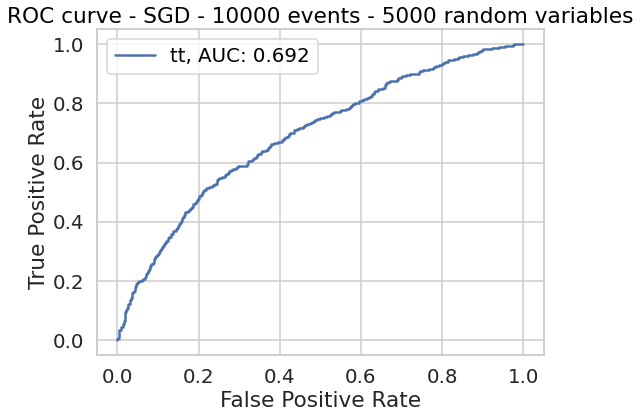

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(roc_sgd[0], roc_sgd[1], label=f'{collision_type}, AUC: {score_sgd:.3f}')
ax.legend()
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'ROC curve - SGD - {nevents} events - {ncomp} random variables')
fig.savefig(out_path + 'roc_sgd_{nevents}events_{ncomp}f.png')
plt.show()

##Ridge roc curve

In [19]:
gsrW = RidgeCV(alphas=np.logspace(2, 7, num=25)).fit(X_train, y_train)

In [20]:
pred_ridge = gsrW.predict(X_test)
roc_ridge = roc_curve(y_test, pred_ridge)
score_ridge = roc_auc_score(y_test, pred_ridge)

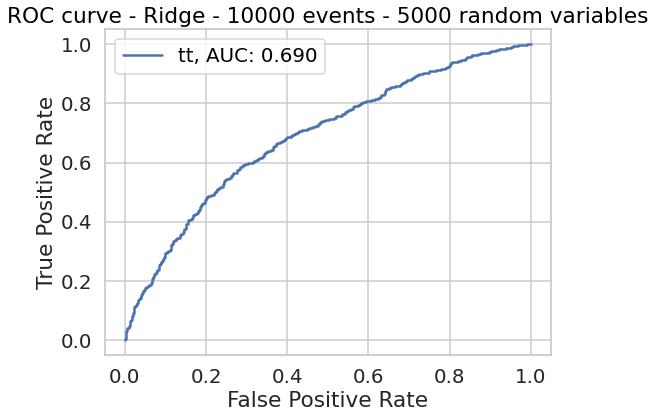

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(roc_ridge[0], roc_ridge[1], label=f'{collision_type}, AUC: {score_ridge:.3f}')
ax.legend()
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'ROC curve - Ridge - {nevents} events - {ncomp} random variables')
fig.savefig(out_path + f'roc_ridge_{nevents}events_{ncomp}f.png')
plt.show()

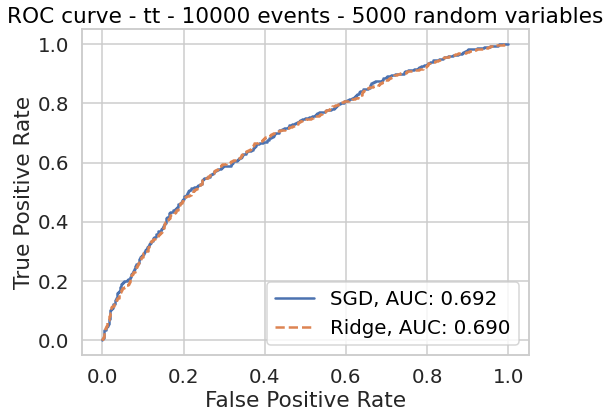

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(roc_sgd[0], roc_sgd[1], label=f'SGD, AUC: {score_sgd:.3f}')
ax.plot(roc_ridge[0], roc_ridge[1], '--', label=f'Ridge, AUC: {score_ridge:.3f}')

ax.legend()
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(f'ROC curve - {collision_type} - {nevents} events - {ncomp} random variables')
fig.savefig(out_path + f'roc_sgdvsridge_{nevents}events_{ncomp}f.png')
plt.show()